### 1. Perkenalan

Nama : Ridha Fuady<br>
Batch : FTDS -011<br>
Dataset : Malaria Detection Dataset<br>
Objective : Made CNN Best Model from Cell Image to Predict Cell Infected Malaria Parasite or Not <br>

### 2. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import cv2
import os
import glob
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import Model
from keras.models import load_model
from keras.utils import to_categorical
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report
import pathlib

### 3. Load Dataset

In [2]:
#check directory
os.listdir('dataset') 

['Test', 'Train']

In [3]:
primary = 'dataset' #declare main path
train_file = os.path.join(primary, 'Train') #declare train path
test_file = os.path.join(primary, 'Test') #declare test path

In [4]:
#set variable infected and uninfected
num_infected = len(os.listdir(os.path.join(train_file, 'Parasite')))
num_uninfected = len(os.listdir(os.path.join(train_file, 'Uninfected')))
print(num_infected)
print(num_uninfected)

220
196


In [5]:
train_infected = glob.glob(train_file + '/Parasite/*.png') #input malaria image into variable
train_uninfected = glob.glob(train_file + '/Uninfected/*.png') #input unifected image into variable

test_infected = glob.glob(test_file + '/Parasite/*.png') #input malaria image into variable
test_uninfected = glob.glob(test_file + '/Uninfected/*.png') #input uninfected image into variable

In [6]:
#make a dataframe
def create_dataframe(list_of_images):
  data=[] #empty data
  for image in list_of_images:
    data.append((image, image.split('/')[-2])) #declare image path

  return pd.DataFrame(data, columns= ['images', 'label'])

train_inf_df= create_dataframe(train_infected) #make data train infected
train_uninf_df= create_dataframe(train_uninfected) #make data train uninfected

test_inf_df= create_dataframe(test_infected) #make data test infected
test_uninf_df= create_dataframe(test_uninfected) #make data test uninfected

In [7]:
#check total counts
test_uninf_df['label'].value_counts()

dataset\Test    43
Name: label, dtype: int64

In [8]:
#change label into parasite and uninfected in data train test
train_inf_df['label'].replace('dataset\Train', '1', inplace=True)
train_uninf_df['label'].replace('dataset\Train', '0', inplace=True)

test_inf_df['label'].replace('dataset\Test', '1', inplace=True)
test_uninf_df['label'].replace('dataset\Test', '0', inplace=True)

train_inf_df

,images,label
0,dataset\Train/Parasite\C133P94ThinF_IMG_201510...,1
1,dataset\Train/Parasite\C133P94ThinF_IMG_201510...,1
2,dataset\Train/Parasite\C133P94ThinF_IMG_201510...,1
3,dataset\Train/Parasite\C133P94ThinF_IMG_201510...,1
4,dataset\Train/Parasite\C133P94ThinF_IMG_201510...,1
...,...,...
215,dataset\Train/Parasite\C39P4thinF_original_IMG...,1
216,dataset\Train/Parasite\C39P4thinF_original_IMG...,1
217,dataset\Train/Parasite\C39P4thinF_original_IMG...,1
218,dataset\Train/Parasite\C39P4thinF_original_IMG...,1


In [9]:
#merge train dataset
train_df = pd.concat([train_inf_df, train_uninf_df], ignore_index=True) #concat data train
train_df= train_df.sample(frac=1, random_state=1).reset_index(drop=True) #shuffle the data
train_df

,images,label
0,dataset\Train/Uninfected\C2NThinF_IMG_20150604...,0
1,dataset\Train/Parasite\C33P1thinF_IMG_20150619...,1
2,dataset\Train/Uninfected\C241NThinF_IMG_201512...,0
3,dataset\Train/Parasite\C39P4thinF_original_IMG...,1
4,dataset\Train/Parasite\C33P1thinF_IMG_20150619...,1
...,...,...
411,dataset\Train/Uninfected\C1_thinF_IMG_20150604...,0
412,dataset\Train/Parasite\C189P150ThinF_IMG_20151...,1
413,dataset\Train/Uninfected\C3thin_original_IMG_2...,0
414,dataset\Train/Uninfected\C1_thinF_IMG_20150604...,0


In [10]:
#merge data test 
test_df = pd.concat([test_inf_df, test_uninf_df], ignore_index=True) #concat data test
test_df= test_df.sample(frac=1, random_state=1).reset_index(drop=True) #shuffle the data
test_df

,images,label
0,dataset\Test/Parasite\C39P4thinF_original_IMG_...,1
1,dataset\Test/Parasite\C39P4thinF_original_IMG_...,1
2,dataset\Test/Uninfected\C3thin_original_IMG_20...,0
3,dataset\Test/Parasite\C39P4thinF_original_IMG_...,1
4,dataset\Test/Parasite\C39P4thinF_original_IMG_...,1
...,...,...
129,dataset\Test/Parasite\C39P4thinF_original_IMG_...,1
130,dataset\Test/Uninfected\C3thin_original_IMG_20...,0
131,dataset\Test/Parasite\C39P4thinF_original_IMG_...,1
132,dataset\Test/Parasite\C39P4thinF_original_IMG_...,1


### 4. Exploratory Data Analysis

In [11]:
#plot infected cell
parasite_samples= (train_df[train_df['label']=='1']['images'].iloc[:10]).tolist()
uninfected_samples= (train_df[train_df['label']=='0']['images'].iloc[:10]).tolist()

def visualize_samples(samples):
  fig,ax= plt.subplots(nrows=2, ncols=5, figsize= (28,15))
  for i, sample in enumerate(samples):
    img= cv2.imread(sample)
    ax[i//5, i%5].set_title(sample.split('/')[-2])
    ax[i//5, i%5].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.show()

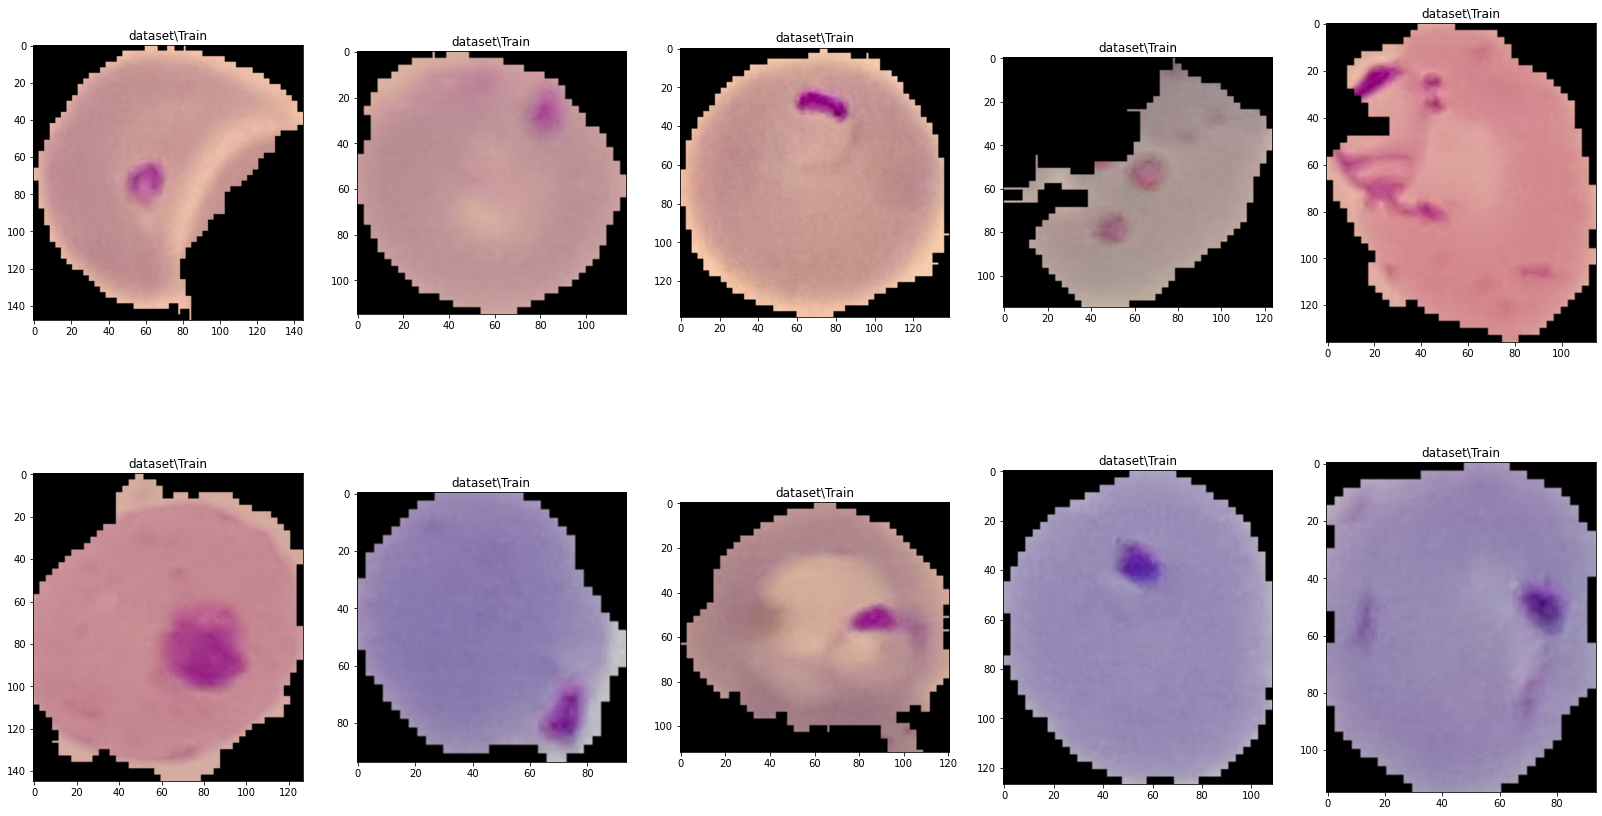

In [12]:
#plot infected image
visualize_samples(parasite_samples)

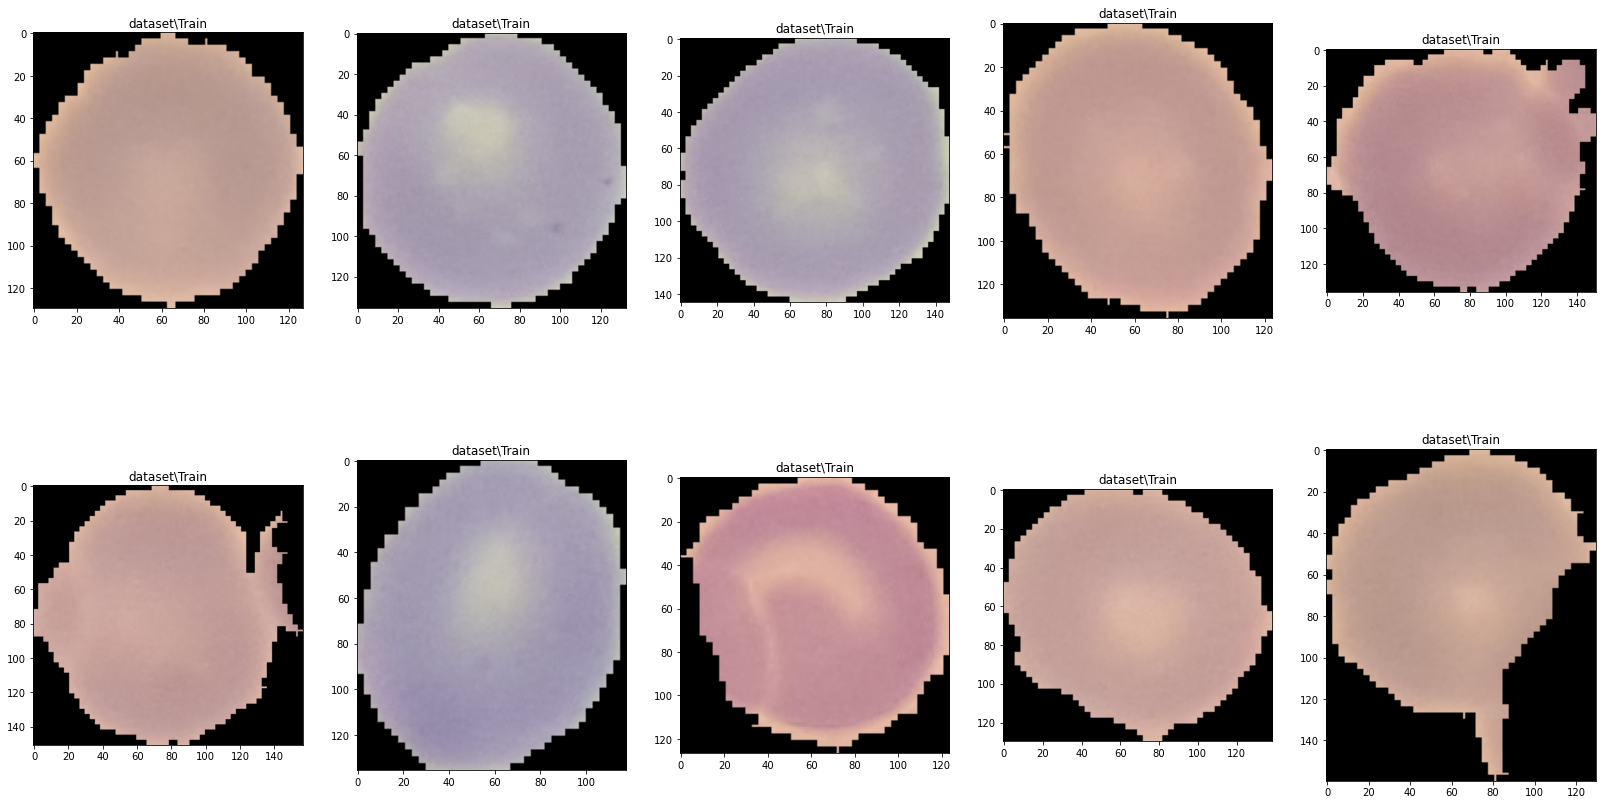

In [13]:
#plot uninfected image
visualize_samples(uninfected_samples)

* Dari hasil plot image parasite malaria dan uninfected malaria dapat diketahui bahwa sel darah yang sehat dapat kita lihat sel darah nya tergambar bersih tidak ada bercak dari sebuah parasit. 
* Berbeda dengan sel darah yang telah terinfeksi malaria dapat kita lihat pada hasil plot nya dimana sel darah merah nya terdapat bercak yang disebabkan oleh parasit yang menyerang sel darah
* Sel darah yang terinfeksi penyakit malaria memiliki patterns yang berbeda-beda, bisa berbeda berdasarkan ukuran parasit nya, atau juga bisa berdasarkan jumlah parasit dalam satu sel darah. Berdasarkan bentuknya, parasit malaria berbentuk bulat hingga oval dan memiliki warna antara pink hingga unggu.

c:\Users\Fuad\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<function matplotlib.pyplot.show(close=None, block=None)>

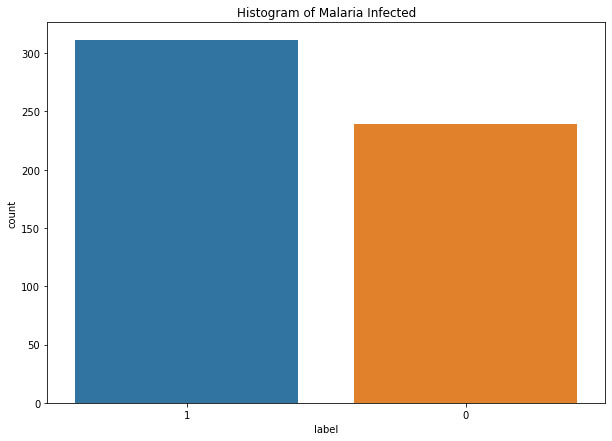

In [14]:
eda = pd.concat([train_df, test_df], ignore_index=True)
eda = eda.sample(frac=1, random_state=1).reset_index(drop=True)

plt.figure(figsize=(10,7))

#looking total parasite and uninfected
sns.countplot("label", data = eda)
plt.title("Histogram of Malaria Infected")

plt.show

Dari chart diatas dapat diketahui bahwa jumlah data untuk parasit berada pada 300an lebih sedangkan untuk data uninfected berada pada mendekati 250

([<matplotlib.patches.Wedge at 0x2320f34ceb0>,
 [Text(-0.22460394699616545, 1.0768254579985301, '1'),
  Text(0.2246039469961651, -1.0768254579985301, '0')],
 [Text(-0.12251124381609023, 0.5873593407264709, '56.55%'),
  Text(0.12251124381609003, -0.5873593407264709, '43.45%')])

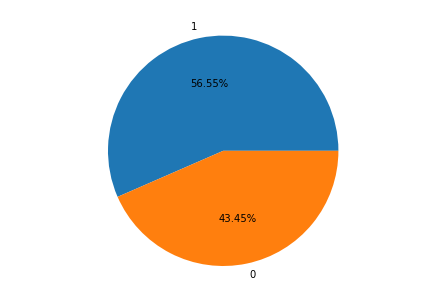

In [15]:
#plotting pie chart, check imbalance data
eda_pie = eda["label"].value_counts().rename_axis("label").reset_index(name="counts")
eda_labels = eda_pie.label
eda_values = eda_pie.counts

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis("equal")
ax.pie(eda_values, labels=eda_labels, autopct='%1.2f%%')

Dari hasil pie chart diketahui bahwa dataset malaria merupakan dataset yang balance dimana persentase antara class parasite dan uninfected tidak terpaut jauh, dan ini termasuk hal yang cukup baik karena akan berpengaruh kepada hasil modeling nanti untuk mengurangi potensi overfit

### 5. Data Preprocessing

In [16]:
#check shape
print(train_df.shape)
print(test_df.shape)

(416, 2)
(134, 2)


In [17]:
#splitting train and val set
val_df, train_df = train_test_split(train_df, train_size=0.25, random_state=1)
print(train_df.shape)
print(test_df.shape)
print(val_df.shape)

(312, 2)
(134, 2)
(104, 2)


In [18]:
#set image shape
img_height= 220
img_width= 220
SEED= 1
BATCH= 32

### Data Augmentation

Sebelum melakukan pembuatan arsitektur data kita perlu melakukan data augmentasi dikarenakan data train yang relatif sedikit yang dikhawatirkan akan menimbulkan overfit saat dievaluasi.

In [19]:
#augmentaion data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=90,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

val_datagen= ImageDataGenerator(rescale= 1./255)
test_datagen= ImageDataGenerator(rescale= 1./255)

In [20]:
# Create a tf.data pipeline of augmented images
#train_pipe = tf.data.Dataset.from_tensor_slices((train_df))
#train_pipe = train_pipe.batch(32).map(lambda x: (train_datagen(x)))

In [21]:
ds_train = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'images',
    y_col = 'label',
    target_size = (img_height, img_width),
    class_mode = 'binary', #binary because just 2 label
    BATCH = BATCH,
    shuffle = True,
    seed = SEED
)

ds_val = val_datagen.flow_from_dataframe(
    dataframe = val_df,
    x_col = 'images',
    y_col = 'label',
    target_size = (img_height, img_width),
    class_mode = 'binary', #binary because just 2 label
    BATCH = BATCH,
    shuffle = False,
    seed = SEED
)

ds_test = test_datagen.flow_from_dataframe(
    dataframe = test_df,
    x_col = 'images',
    y_col = 'label',
    target_size = (img_height, img_width),
    class_mode = 'binary', #binary because just 2 label
    BATCH = BATCH,
    shuffle = False,
    seed = SEED
)

Found 312 validated image filenames belonging to 2 classes.
Found 104 validated image filenames belonging to 2 classes.
Found 134 validated image filenames belonging to 2 classes.


In [22]:
ds_train.class_indices

{'0': 0, '1': 1}

### 6. Model Definition Sequence API

In [23]:
#build architecture model sequence API
input = [img_height, img_width, 3]

model_seq = Sequential()
#Conv1
model_seq.add(Conv2D(filters=16, kernel_size = 3, activation='relu', input_shape=input))
model_seq.add(MaxPooling2D(pool_size=2, strides=2))

#Conv2
model_seq.add(Conv2D(filters=32, kernel_size = 3, activation='relu', input_shape=input))
model_seq.add(MaxPooling2D(pool_size=2, strides=2))

model_seq.add(Flatten())
model_seq.add(Dense(units=64, activation='relu'))

model_seq.add(Dense(units=1, activation='sigmoid'))

In [24]:
model_seq.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 218, 218, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 109, 109, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 107, 107, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 89888)             0         
                                                                 
 dense (Dense)               (None, 64)                5

In [25]:
model_seq.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### 7. Model Training Sequence API

In [26]:
#train the model sequence API
epochs = 30
history_seq = model_seq.fit(ds_train, batch_size=BATCH, epochs=epochs,
                        validation_data=ds_val, verbose=1)

Epoch 1/30
10/10 [==============================] - 5s 449ms/step - loss: 0.8767 - accuracy: 0.5385 - val_loss: 0.6287 - val_accuracy: 0.5385
Epoch 2/30
10/10 [==============================] - 4s 431ms/step - loss: 0.5870 - accuracy: 0.6506 - val_loss: 0.4933 - val_accuracy: 0.7308
Epoch 3/30
10/10 [==============================] - 4s 439ms/step - loss: 0.4941 - accuracy: 0.7244 - val_loss: 0.4838 - val_accuracy: 0.7500
Epoch 4/30
10/10 [==============================] - 4s 427ms/step - loss: 0.4913 - accuracy: 0.7308 - val_loss: 0.4977 - val_accuracy: 0.7500
Epoch 5/30
10/10 [==============================] - 4s 447ms/step - loss: 0.4980 - accuracy: 0.7212 - val_loss: 0.4086 - val_accuracy: 0.8558
Epoch 6/30
10/10 [==============================] - 4s 432ms/step - loss: 0.4447 - accuracy: 0.8013 - val_loss: 0.3707 - val_accuracy: 0.8173
Epoch 7/30
10/10 [==============================] - 4s 423ms/step - loss: 0.4229 - accuracy: 0.8013 - val_loss: 0.4063 - val_accuracy: 0.8077
Epoch 

### 8. Model Evaluation Sequence API

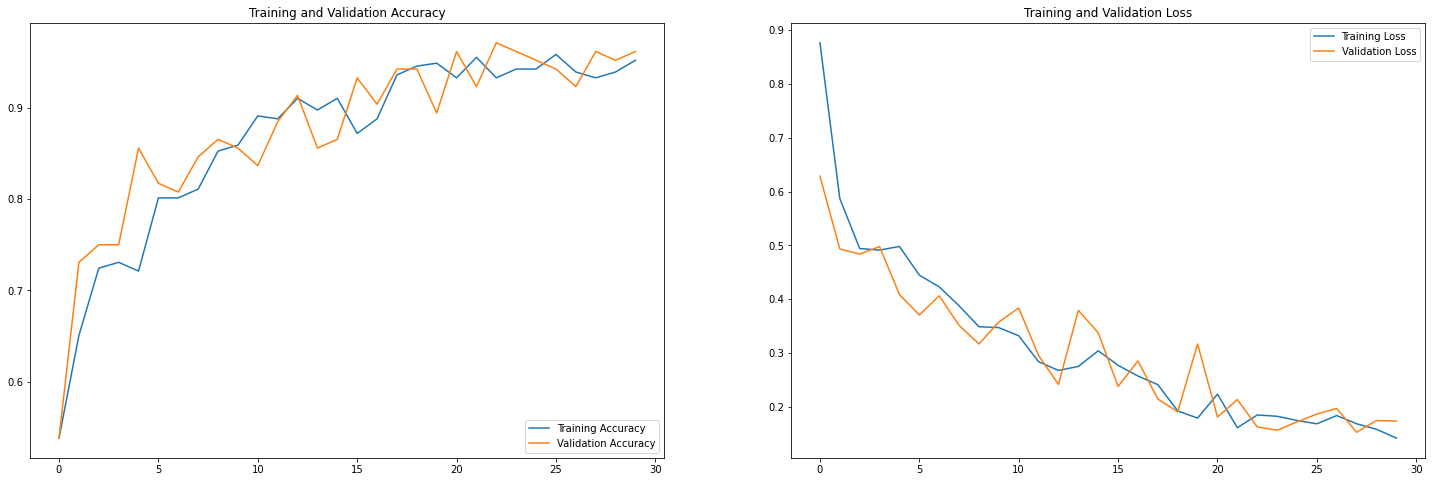

In [27]:
#plot accuracy and loss train and val set
acc = history_seq.history['accuracy']
val_acc = history_seq.history['val_accuracy']

loss = history_seq.history['loss']
val_loss = history_seq.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(25, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

* Berdasarkan evaluasi accuracy dan loss dari model sequence API dapat kita lihat bahwa hasil accuracy antara data train dengan data val tidak terlalu signifikan perbedaannya dan ini merupakan hasil yang cukup good fit.
* Hasil accuracy antara train dan validation bergerak dominan naik dan tidak mengalami kenaikan setelah epoch 20
* Jika kita lihat dari hasil loss antara train dan validasi, hasil loss juga menggambarkan hasil yang baik dimana jarak antara train and validasi nya tidak terlalu jauh
* Hasil loss antara train dan validasi cukup baik dikarenakan hasil loss nya turun untuk setiap epoch nya hana saja untuk validation beberapa kali mengalami peningkatan nilai loss
* Hasil model sequence API cukup baik dengan nilai accuracy terakhir yaitu 0.9519 dan loss 0.14 pada epoch terakhir dan hasil ini termasuk goodfit

### 6. Model Definition Function API

In [28]:
#make architecture model function API
def model_2():
    inputs = Input(shape=input)
    hidden = Conv2D(16, kernel_size=3, activation='relu')(inputs)
    hidden = MaxPooling2D()(hidden)
    hidden = Conv2D(32, kernel_size=3, activation='relu')(inputs)
    hidden = MaxPooling2D()(hidden)
    hidden = Flatten()(hidden)
    hidden = Dense(64)(hidden)
    output = Dense(1, activation='sigmoid')(hidden)
    model = Model(inputs=inputs, outputs=output)
    return model

In [29]:
model = model_2()

In [30]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 220, 220, 3)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 218, 218, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 109, 109, 32)     0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 380192)            0         
                                                                 
 dense_2 (Dense)             (None, 64)                24332352  
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                             

### 7. Model Training Function API

In [31]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [32]:
#train model function API
history_func = model.fit(ds_train, batch_size=BATCH, epochs=epochs,
                        validation_data=ds_val, verbose=1)

Epoch 1/30
10/10 [==============================] - 5s 476ms/step - loss: 12.4055 - accuracy: 0.5929 - val_loss: 6.8582 - val_accuracy: 0.6731
Epoch 2/30
10/10 [==============================] - 5s 476ms/step - loss: 2.9571 - accuracy: 0.6763 - val_loss: 2.5403 - val_accuracy: 0.6731
Epoch 3/30
10/10 [==============================] - 5s 469ms/step - loss: 1.7790 - accuracy: 0.6603 - val_loss: 1.2512 - val_accuracy: 0.6442
Epoch 4/30
10/10 [==============================] - 5s 466ms/step - loss: 0.7334 - accuracy: 0.7340 - val_loss: 0.7106 - val_accuracy: 0.6058
Epoch 5/30
10/10 [==============================] - 5s 470ms/step - loss: 0.5620 - accuracy: 0.7212 - val_loss: 0.4923 - val_accuracy: 0.7788
Epoch 6/30
10/10 [==============================] - 5s 474ms/step - loss: 0.4822 - accuracy: 0.7692 - val_loss: 0.5247 - val_accuracy: 0.7212
Epoch 7/30
10/10 [==============================] - 5s 463ms/step - loss: 0.4816 - accuracy: 0.7628 - val_loss: 0.4208 - val_accuracy: 0.8077
Epoch

### 8. Model Evaluation Function API

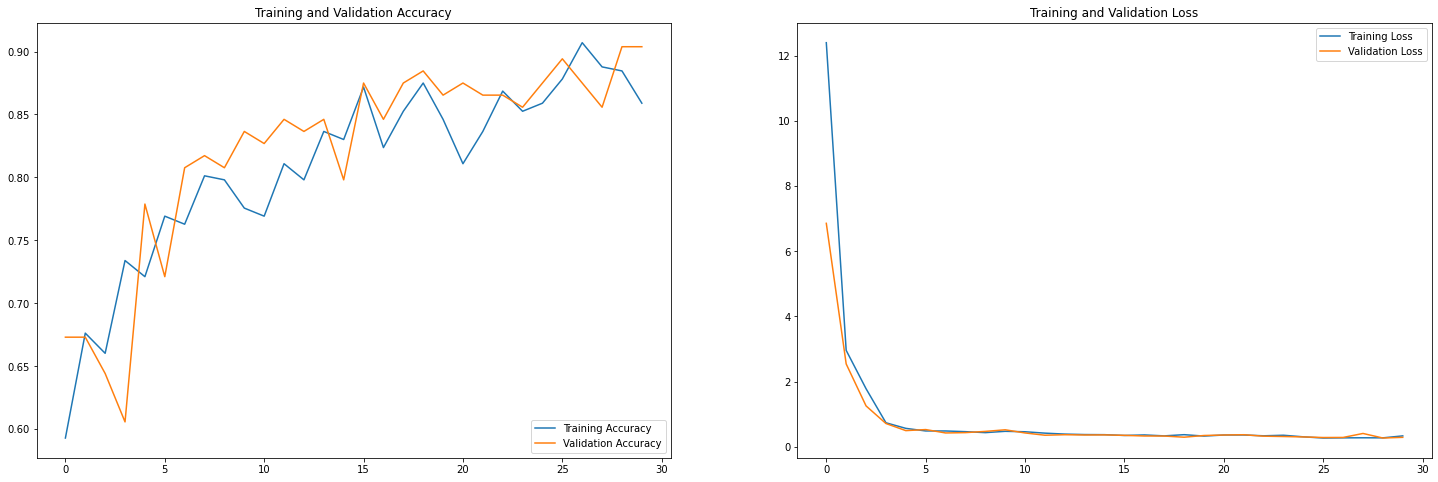

In [33]:
#plot result function API
acc_2 = history_func.history['accuracy']
val_acc_2 = history_func.history['val_accuracy']

loss_2 = history_func.history['loss']
val_loss_2 = history_func.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(25, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc_2, label='Training Accuracy')
plt.plot(epochs_range, val_acc_2, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_2, label='Training Loss')
plt.plot(epochs_range, val_loss_2, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

* Berdasarkan evaluasi accuracy dan loss dari model function API dapat kita lihat bahwa hasil accuracy antara data train dengan data val pada epoch terakhir terdapat perbedaan yang cukup jauh dimana perbedaan accuracy train dan validasi nya berbeda 0.5.
* Hasil accuracy antara train dan validation bergerak dominan naik dan diprediksi masih akan terus naik jika kita memperbanyak nilai epoch nya.
* Jika kita lihat dari hasil loss antara train dan validasi, hasil loss juga menggambarkan hasil yang baik dimana jarak antara train and validasi nya tidak terlalu jauh
* Hasil loss antara train dan validasi cukup baik dikarenakan hasil loss nya turun untuk setiap epoch nya dan diperkirakan nilai loss ini akan bisa bertambah turun jika kita memperbanyak epoch nya.
* Hasil model function API cukup baik dengan nilai accuracy terakhir yaitu 0.8590 dan loss 0.33 pada epoch terakhir dan hasil ini termasuk goodfit.

#### Sequence and Function Comparison
* Jika kita lihat dari hasil accuracy model sequence lebih baik dibanding model function
* Jika kita lihat dari hasil loss model sequence lebih baik dibanding model function
* perbedaan accuracy train dan dan validasi model sequence lebih sedikit dan lebih baik dibanding model function
* Dari hasil comparasi ini maka saya akan melakukan tuning tambahan pada model sequence untuk mendapatkan performa yang lebih baik lagi dengan cara penambahan layer, normalization dan drop out

### 6. Model Definition Sequence API with Tuning

In [34]:
#set callbacks
callbacks= [
            ModelCheckpoint('model_best.hdf5', monitor='val_loss', save_best_only= True),
            ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1, factor=0.3, min_lr=0.01)]
            #EarlyStopping(monitor= 'val_loss', mode='min', patience= 2, verbose=1),]

In [35]:
#make architecture model sequence with adding more tuning
model_tune = Sequential()

model_tune.add(Conv2D(filters=32, kernel_size = 3, activation='relu', input_shape=input))

#Conv1
model_tune.add(MaxPooling2D(pool_size=3, strides=2))
model_tune.add(BatchNormalization())
model_tune.add(Dropout(0.4))

#Conv2
model_tune.add(Conv2D(filters=64, kernel_size = 3, activation='relu'))
model_tune.add(MaxPooling2D(pool_size=3, strides=2))
model_tune.add(BatchNormalization())
model_tune.add(Dropout(0.4))

#Conv3
model_tune.add(Conv2D(filters=128, kernel_size = 3, activation='relu'))
model_tune.add(MaxPooling2D(pool_size=3, strides=2))
model_tune.add(BatchNormalization())
model_tune.add(Dropout(0.4))

#Conv4
model_tune.add(Conv2D(filters=256, kernel_size = 3, activation='relu'))
model_tune.add(MaxPooling2D(pool_size=3, strides=2))
model_tune.add(BatchNormalization())
model_tune.add(Dropout(0.4))

#Conv5
model_tune.add(Conv2D(filters=512, kernel_size = 3, activation='relu'))
model_tune.add(MaxPooling2D(pool_size=3, strides=2))
model_tune.add(BatchNormalization())
model_tune.add(Dropout(0.4))

model_tune.add(Flatten())

model_tune.add(Dense(units=16, activation='relu'))
model_tune.add(BatchNormalization())
model_tune.add(Dropout(0.5))

model_tune.add(Dense(units=8, activation='relu'))
model_tune.add(BatchNormalization())
model_tune.add(Dropout(0.5))

model_tune.add(Dense(units=1, activation='sigmoid'))

In [36]:
model_tune.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.002, clipvalue=1.0), loss='binary_crossentropy', metrics=['accuracy'])

In [37]:
model_tune.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 218, 218, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 108, 108, 32)     0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 108, 108, 32)     128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 108, 108, 32)      0         
                                                                 
 conv2d_5 (Conv2D)           (None, 106, 106, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 52, 52, 64)      

### 7. Model Training Sequence API with Tuning

In [38]:
#train model sequence with tuning
history_tune = model_tune.fit(ds_train, batch_size=BATCH, epochs=100,
                        validation_data=ds_val, callbacks=callbacks, verbose=1)

Epoch 1/100
10/10 [==============================] - 13s 1s/step - loss: 0.7373 - accuracy: 0.6410 - val_loss: 0.6896 - val_accuracy: 0.5288 - lr: 0.0020
Epoch 2/100
10/10 [==============================] - 12s 1s/step - loss: 0.7564 - accuracy: 0.6474 - val_loss: 0.6543 - val_accuracy: 0.7115 - lr: 0.0020
Epoch 3/100
10/10 [==============================] - 11s 1s/step - loss: 0.6257 - accuracy: 0.6731 - val_loss: 0.6814 - val_accuracy: 0.5288 - lr: 0.0020
Epoch 4/100
10/10 [==============================] - 11s 1s/step - loss: 0.5751 - accuracy: 0.6795 - val_loss: 0.8467 - val_accuracy: 0.5288 - lr: 0.0020
Epoch 5/100
10/10 [==============================] - 11s 1s/step - loss: 0.5583 - accuracy: 0.7051 - val_loss: 0.7018 - val_accuracy: 0.5769 - lr: 0.0020
Epoch 6/100
10/10 [==============================] - 11s 1s/step - loss: 0.4614 - accuracy: 0.8141 - val_loss: 1.0965 - val_accuracy: 0.4712 - lr: 0.0020
Epoch 7/100
10/10 [==============================] - 11s 1s/step - loss: 0.5

### 8. Model Evaluation Sequence API with Tuning

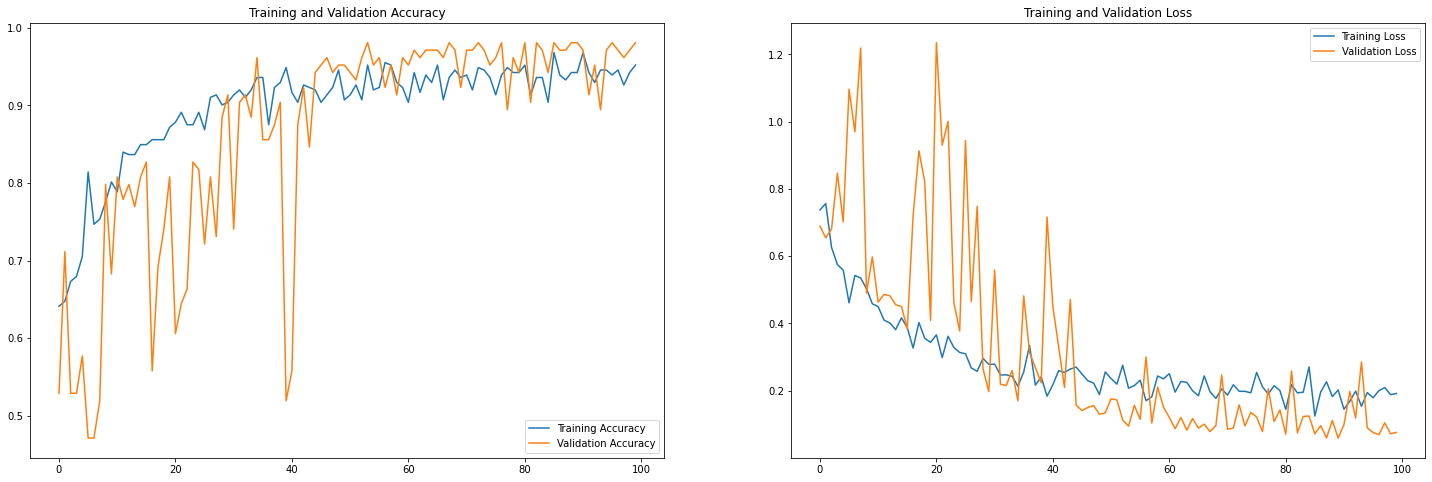

In [39]:
#plot result model sequence API with tuning
acc_tune = history_tune.history['accuracy']
val_acc_tune = history_tune.history['val_accuracy']

loss_tune = history_tune.history['loss']
val_loss_tune = history_tune.history['val_loss']

epochs = [i for i in range(100)]

plt.figure(figsize=(25, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc_tune, label='Training Accuracy')
plt.plot(epochs, val_acc_tune, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs, loss_tune, label='Training Loss')
plt.plot(epochs, val_loss_tune, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

* Berdasarkan evaluasi accuracy dan loss dari model sequence API dapat kita lihat bahwa hasil accuracy antara data train dengan data val pada epoch terakhir terdapat perbedaan yang tidak signifikan dimana perbedaan accuracy train dan validasi nya berbeda 0.3.
* Hasil accuracy antara train dan validation bergerak dominan naik tetapi tidak mengalami kenaikan lagi setelah melewati epoch ke 35
* Berdasarkan nilai accuracy validasi, beberapa kali terjadi penurunan score accuracy yang sangat jauh pada epoch 38
* Jika kita lihat dari hasil loss antara train dan validasi, hasil loss juga menggambarkan hasil yang baik dimana jarak antara train and validasi nya tidak terlalu jauh
* Hasil loss antara train dan validasi cukup baik dikarenakan hasil loss nya turun untuk setiap epoch nya tetapi setelah epoch ke 40 penurunan nilai epoch sudah tidak terjadi atau stagnan
* Hasil model sequence API after tuning cukup baik dengan nilai accuracy terakhir yaitu 0.9519 dan loss 0.19 pada epoch terakhir dan hasil ini termasuk goodfit.

#### Sequence before and after tuning Comparison
* Jika kita lihat dari hasil accuracy model sequence after tuning hasil ini sama persis jika dibandingkan dengan sebelum dilakukan tuning tambahan
* Jika kita lihat dari hasil loss model sequence after tuning sedikit lebih tinggi jika dibandingkan model sequence sebelum tuning
* perbedaan accuracy train dan dan validasi model sequence before tuning dan after tuning tidak terdapat hasil yang berbeda secara signifikan
* Dari hasil comparasi ini maka saya akan melakukan tuning tambahan pada model sequence after tuning dengan input pipeline untuk mendapatkan performa yang lebih baik lagi dan hasil yang lebih cepat dalam proses training model nya

### Using Pipeline for Better Result

In [40]:
data_dir = pathlib.Path(primary)

In [41]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

#make pipeline
def pipeline_tuning(image, label):
    image = tf.image.random_flip_left_right(image)
    return image, label

In [42]:
train_pipe = tf.keras.preprocessing.image_dataset_from_directory(data_dir, 
                                                                validation_split=0.2,
                                                                subset='training',
                                                                seed=SEED,
                                                                image_size=(img_height, img_width),
                                                                batch_size=BATCH)

val_pipe = tf.keras.preprocessing.image_dataset_from_directory(data_dir, 
                                                                validation_split=0.2,
                                                                subset='validation',
                                                                seed=SEED,
                                                                image_size=(img_height, img_width),
                                                                batch_size=BATCH)

Found 550 files belonging to 2 classes.
Using 440 files for training.
Found 550 files belonging to 2 classes.
Using 110 files for validation.


In [43]:
#normalize image shape
normalization_layer = tf.keras.layers.Rescaling(1./255)

data_normalize = train_pipe.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(data_normalize))
first_image = image_batch[0]

# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.8854655


In [44]:
train_pipe = train_pipe.cache().prefetch(buffer_size=AUTOTUNE)
train_pipe = train_pipe.map(pipeline_tuning, num_parallel_calls=AUTOTUNE)

val_pipe = val_pipe.cache().prefetch(buffer_size=AUTOTUNE)

In [45]:
#make architecture model sequence api with pipeline tuning
model_pipetune= Sequential()

model_pipetune.add(Conv2D(filters=32, kernel_size = 3, activation='relu', input_shape=input))

#Conv1
model_pipetune.add(MaxPooling2D(pool_size=3, strides=2))
model_pipetune.add(BatchNormalization())
model_pipetune.add(Dropout(0.4))

#Conv2
model_pipetune.add(Conv2D(filters=64, kernel_size = 3, activation='relu'))
model_pipetune.add(MaxPooling2D(pool_size=3, strides=2))
model_pipetune.add(BatchNormalization())
model_pipetune.add(Dropout(0.4))

#Conv3
model_pipetune.add(Conv2D(filters=128, kernel_size = 3, activation='relu'))
model_pipetune.add(MaxPooling2D(pool_size=3, strides=2))
model_pipetune.add(BatchNormalization())
model_pipetune.add(Dropout(0.4))

#Conv4
model_pipetune.add(Conv2D(filters=256, kernel_size = 3, activation='relu'))
model_pipetune.add(MaxPooling2D(pool_size=3, strides=2))
model_pipetune.add(BatchNormalization())
model_pipetune.add(Dropout(0.4))

#Conv5
model_pipetune.add(Conv2D(filters=512, kernel_size = 3, activation='relu'))
model_pipetune.add(MaxPooling2D(pool_size=3, strides=2))
model_pipetune.add(BatchNormalization())
model_pipetune.add(Dropout(0.4))

model_pipetune.add(Flatten())

model_pipetune.add(Dense(units=16, activation='relu'))
model_pipetune.add(BatchNormalization())
model_pipetune.add(Dropout(0.5))

model_pipetune.add(Dense(units=8, activation='relu'))
model_pipetune.add(BatchNormalization())
model_pipetune.add(Dropout(0.5))

model_pipetune.add(Dense(units=1, activation='sigmoid'))

In [46]:
model_pipetune.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.002, clipvalue=1.0), loss='binary_crossentropy', metrics=['accuracy'])

In [47]:
#train model sequence api with pipeline and tuning
history_pipetune = model_pipetune.fit(train_pipe, batch_size=BATCH, epochs=100,
                        validation_data=val_pipe, callbacks=callbacks, verbose=1)

Epoch 1/100
14/14 [==============================] - 17s 1s/step - loss: 0.8870 - accuracy: 0.5659 - val_loss: 4.6842 - val_accuracy: 0.7636 - lr: 0.0020
Epoch 2/100
14/14 [==============================] - 15s 1s/step - loss: 0.8042 - accuracy: 0.5614 - val_loss: 3.4084 - val_accuracy: 0.7636 - lr: 0.0020
Epoch 3/100
14/14 [==============================] - 15s 1s/step - loss: 0.8129 - accuracy: 0.5795 - val_loss: 0.5947 - val_accuracy: 0.7091 - lr: 0.0020
Epoch 4/100
14/14 [==============================] - 15s 1s/step - loss: 0.7450 - accuracy: 0.5773 - val_loss: 0.9066 - val_accuracy: 0.2818 - lr: 0.0020
Epoch 5/100
14/14 [==============================] - 15s 1s/step - loss: 0.7596 - accuracy: 0.6159 - val_loss: 2.2701 - val_accuracy: 0.2364 - lr: 0.0020
Epoch 6/100
14/14 [==============================] - 15s 1s/step - loss: 0.6965 - accuracy: 0.6227 - val_loss: 1.0956 - val_accuracy: 0.7636 - lr: 0.0020
Epoch 7/100
14/14 [==============================] - 15s 1s/step - loss: 0.6

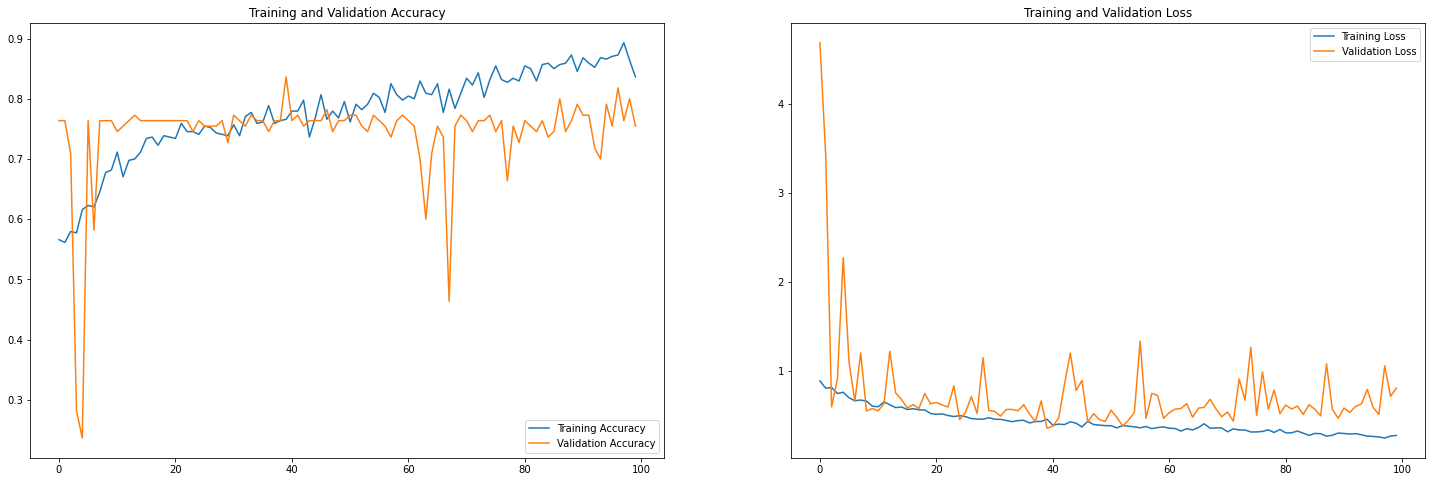

In [48]:
#plot the result model sequence api with pipeline tuning
acc_pipetune = history_pipetune.history['accuracy']
val_acc_pipetune = history_pipetune.history['val_accuracy']

loss_pipetune = history_pipetune.history['loss']
val_loss_pipetune = history_pipetune.history['val_loss']

epochs = [i for i in range(100)]

plt.figure(figsize=(25, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc_pipetune, label='Training Accuracy')
plt.plot(epochs, val_acc_pipetune, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs, loss_pipetune, label='Training Loss')
plt.plot(epochs, val_loss_pipetune, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

* Berdasarkan evaluasi accuracy dan loss dari model sequence API with pipeline and tuning dapat kita lihat bahwa hasil accuracy antara data train dengan data val pada epoch tidak melebihi model sebelum ditambahkan nya pipeline dimana skor tidak melebihi 0.9
* Hasil accuracy antara train dan validation bergerak dominan naik tetapi hasil ini masih dapat diprediksi terjadi kenaikan jika epoch diperbanyak
* Berdasarkan nilai accuracy validasi, beberapa kali terjadi penurunan score accuracy yang sangat jauh pada epoch 3-5.
* Terjadi vanishing gradient pada validation accuracy pada epoch 6-25
* Jika kita lihat dari hasil loss antara train dan validasi, hasil loss juga menggambarkan hasil yang tidak terlalu baik pada epoch 60 keatas dimana validation loss mengalami kenaikan sedikit demi sedikit dan bergerak menjauhi training loss
* Hasil loss antara train dan validasi tidak terlalu baik dikarenakan hasil loss nya turun untuk setiap epoch nya pada training dan naik pada validation, dan membuat perbedaan antara train loss dan val loss menjadi jauh
* Hasil model sequence API after tuning + pipeline tidak terlalu baik dengan nilai accuracy terakhir yaitu 0.7614 dan loss 0.38 pada epoch terakhir dan hasil ini tidak goodfit.

#### Sequence before and after tuning + pipeline Comparison 
* Jika kita lihat dari hasil accuracy model sequence tanpa pipeline hasil ini lebih baik jika kita menggunakan pipeline
* Jika kita lihat dari hasil loss model sequence tanpa pipeline lebih baik jika dibandingkan model sequence menggunakan pipeline
* perbedaan accuracy train dan dan validasi model sequence dengan pipeline dan tanpa pipeline terdapat hasil yang berbeda secara signifikan

In [49]:
predict_seq = model_seq.evaluate(ds_test)

5/5 [==============================] - 0s 56ms/step - loss: 0.3020 - accuracy: 0.8582


In [50]:
predict_func = model.evaluate(ds_test)

5/5 [==============================] - 0s 66ms/step - loss: 0.6306 - accuracy: 0.6791


In [51]:
predict_tune = model_tune.evaluate(ds_test)

5/5 [==============================] - 1s 176ms/step - loss: 0.2175 - accuracy: 0.9328


In [52]:
predict_pipetune = model_pipetune.evaluate(ds_test)

5/5 [==============================] - 1s 180ms/step - loss: 1.5817 - accuracy: 0.6791


In [53]:
print(f'Loss Sequence API : {predict_seq[0]}')
print(f'Accuracy Sequence API : {predict_seq[1]}')

Loss Sequence API : 0.3019503951072693
Accuracy Sequence API : 0.858208954334259


In [54]:
print(f'Loss Function API : {predict_func[0]}')
print(f'Accuracy Function API : {predict_func[1]}')

Loss Function API : 0.6305944323539734
Accuracy Function API : 0.6791045069694519


In [55]:
print(f'Loss Sequence API tuning: {predict_tune[0]}')
print(f'Accuracy Sequence API tuning: {predict_tune[1]}')

Loss Sequence API tuning: 0.21746446192264557
Accuracy Sequence API tuning: 0.9328358173370361


In [56]:
print(f'Loss Sequence API pipeline tune: {predict_pipetune[0]}')
print(f'Accuracy Sequence API pipeline tune: {predict_pipetune[1]}')

Loss Sequence API pipeline tune: 1.5816932916641235
Accuracy Sequence API pipeline tune: 0.6791045069694519


* Berdasarkan hasil evaluasi nya dapat diketahui bahwa nilai loss terendah terdapat pada model sequence with tuning dan tanpa menggunakan pipeline dengan score 0.21 dan accuracy terbaik juga diraih oleh model yang sama dengan score 0.93.
* Model terburuk terdapat pada model sequence API with tuning dan tambah pipeline dimana score loss nya sangat tinggi yaitu 1.5 dan accuracy yang rendah yaitu 0.67

### Alasan menggunakan pipeline hasil malah menjadi rendah
* Alasan kenapa model sequence API yang menggunakan pipeline hasil yang didapat lebih rendah dibandingkan tanpa pipeline padahal memiliki architecture model yang sama, alasan nya adalah penggunaan augmentasi data yang berbeda antara kedua model tersebut dimana augmentasi data pada model yang tanpa pipeline memiliki variasi augmentasi data lebih banyak, sedangkan model dengan pipeline augmentasi data nya hanya satu jenis.

* Dari hasil ini saya akan memilih model ketiga yaitu model sequence API dengan tuning dan tanpa pipeline untuk disave dan melakukan prediksi terhadap data baru

### 9. Model Saving

In [65]:
model_tune.save("model_best.h5") #model saving

### 10. Model Inference

In [58]:
#load model
model_predict = load_model('model_best.h5')

In [66]:
#predict data with threshold 0.5
pred = ds_test
predict = model_predict.predict(pred)
y_pred = []
for k in predict:
    if k > 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)
y_pred[:10]

5/5 [==============================] - 1s 166ms/step


[1, 1, 0, 1, 0, 0, 1, 1, 1, 0]

In [60]:
y_test = test_df['label']
y_test[:10]

0    1
1    1
2    0
3    1
4    1
5    0
6    1
7    1
8    1
9    0
Name: label, dtype: object

* Dari hasil predict 10 rows data test didapatkan hasil yang memuaskan dimana hasilnya terprediksi 100% benar
* Selanjutnya kita akan melihat hasil prediksi keseluruhan data test menggunakan confusion matrix untuk mengetahui nilai false positve dan false negative dari model tersebut

In [61]:
y_test2 = y_test.replace(['1', '0'],[1, 0])

In [62]:
np.array(y_test2)

array([1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0,
       0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1], dtype=int64)

<Figure size 432x288 with 0 Axes>

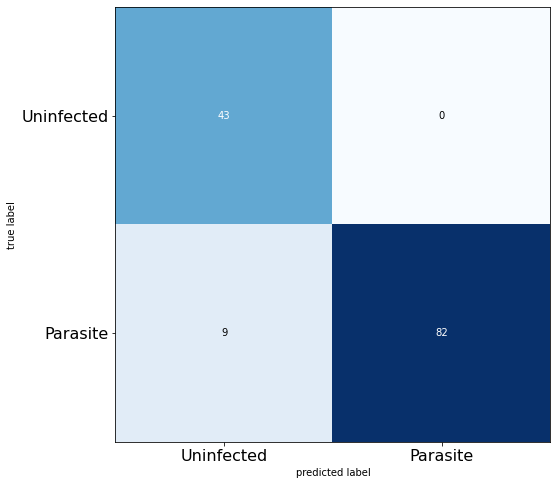

In [63]:
# Get the confusion matrix
conf_matrix  = confusion_matrix(y_test2, y_pred)
plt.figure()
plot_confusion_matrix(conf_matrix,figsize=(12,8))
plt.xticks(range(2), ['Uninfected', 'Parasite'], fontsize=16)
plt.yticks(range(2), ['Uninfected', 'Parasite'], fontsize=16)
plt.show()

In [64]:
# Calculate Precision and Recall
tn, fp, fn, tp = conf_matrix.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))

Recall of the model is 0.90
Precision of the model is 1.00


* Hasil confusion matrix mendapatkan hasil yang sangat baik
* Hasil false positive yang tidak ada sama sekali, tetapi ini sedikit mengkhawatirkan karna khawatir model ini terdapat bias
* Hasil false negative yang lumayan tinggi dimana 9 orang terprediksi uninfected padahal seharusnya terprediksi infected
* Dari hasil precision sangat sempurna yaitu 100% tetapi disini saya memiliki kekhawatiran karna hasil yang 100% sangat lah jarang terjadi dan khawatir bias dalam prediksi nya
* Dari hasil recall cukup baik yaitu 90% dimana masih terdapat 9 pasien yang terprediksi false negative
* Dari hasil ini saya akan merubah sedikit threshold nya untuk menurunkan nilai false negative dimana tinggi nya nilai false negative sangat berbahaya dalam dunia medis dimana pasien sakit tetapi terprediksi tidak sakit sehingga dapat membahayakan nyawa sang pasien karena tidak mendapatkan perawatan yang tepat.

In [80]:
#predict data with threshold 0.5
pred_2 = ds_test
predict_2 = model_predict.predict(pred_2)
y_pred_2 = []
for k in predict_2:
    if k > 0.35:
        y_pred_2.append(1)
    else:
        y_pred_2.append(0)
y_pred_2[:10]

5/5 [==============================] - 1s 167ms/step


[1, 1, 0, 1, 0, 0, 1, 1, 1, 0]

<Figure size 432x288 with 0 Axes>

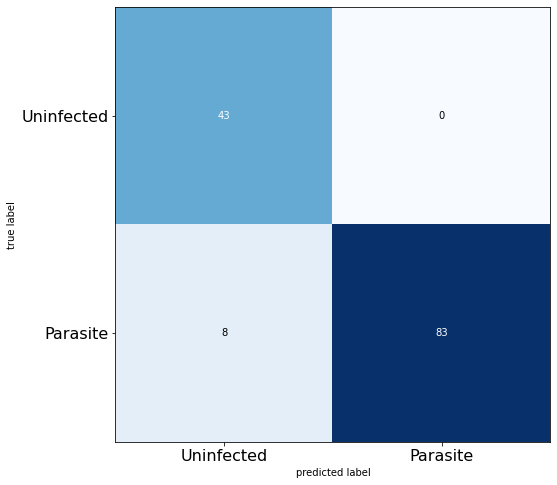

In [81]:
# Get the confusion matrix
conf_matrix_2  = confusion_matrix(y_test2, y_pred_2)
plt.figure()
plot_confusion_matrix(conf_matrix_2,figsize=(12,8))
plt.xticks(range(2), ['Uninfected', 'Parasite'], fontsize=16)
plt.yticks(range(2), ['Uninfected', 'Parasite'], fontsize=16)
plt.show()

In [82]:
# Calculate Precision and Recall
tn_2, fp_2, fn_2, tp_2 = conf_matrix_2.ravel()

precision_2 = tp_2/(tp_2+fp_2)
recall_2 = tp_2/(tp_2+fn_2)

print("Recall of the model is {:.2f}".format(recall_2))
print("Precision of the model is {:.2f}".format(precision_2))

Recall of the model is 0.91
Precision of the model is 1.00


* Dari hasil pengaturan threshold saya menurunkan threshold sebesar 15% dan mendapat kenaikan pada nilai recall sebesar 1%
* Threshold saya turunkan maksimal 15% dikhawatirkan jika diturunkan terlalu banyak akan menghasilkan bias pada hasil false negative nya
* Terjadi penurunan jumlah false negative dari yang awalnya 9 pasien menjadi 8 pasien
* Tidak terjadi perubahan pada false positive

### Conclusion in EDA
* Gambar sel darah yang sehat sangat bersih tidak terdapat unsur atau bercak apapun
* Gambar sel darah yang terserang parasite malaria terdapat gumpalan berbentuk bulat atau oval dan berwarna pink keunguan dan jumlah nya bisa lebih dari satu
* Data balanced dimana class 0 dan 1 nya tidak berbeda jauh.

### Conclusion in Model
* Telah dilakukan permodelan dengan 4 cara, sequence API, function API, sequence API adding tuning, sequence API adding tuning + pipeline
* Hasil terbaik diraih oleh sequence API adding tuning
* Hasil terburuk diraih oleh sequence API adding tuning + pipeline
* Hasil pada model ketiga semakin baik dikarenakan menambahkan normalization, drop out serta penambahan layer pada architecture model nya
* Hasil pada model ketiga juga dilakukan penggantian jenis optimizers dari Adam menjadi RMSprop, dikarenakan terjadi vanishing gradient saat trial and error
* Penambahan feature callback learning rate pada model ketiga
* Hasil buruk pada model 4 ada beberapa kemungkinan, dan yang paling utama kemungkinan terjadi pada data augmentasi yang berbeda dibandingkan model 1 2 dan 3 dimana data augmentasi yang digunakan hanya satu jenis yaitu flip left right yang menyebabkan overfit dan terjadi vanishing gradient
* Model evaluasi pada model ketiga mendapatkan hasil yang baik dimana nilai loss hanya 0.21 dan accuracy sebesar 0.93
* Evaluasi confusion matrix pada model ketiga tidak mendapatkan false positive sama sekali dan mendapatkan false negative sebanyak 9 orang
* Mendapatkan precision 100% dan recal 90%
* Pada kasus ini kita perlu fokus kepada score recall, dengan cara meminimalkan false negative dimana hal ini sangat berbahaya dikalangan medis dimana seorang pasien diprediksi sehat padahal kondisi aslinya pasien tersebut sakit
* Setelah setting penurunan nilai threshold sebesar 15% terjadi kenaikan pada nilai recall sebesar 1% menjadi 91%
* Terjadi penurunan false negative setelah setting penurunan threshold dari awalnya sebanyak 9 pasien menjadi 8 pasien